# **Csomagok behívása**

In [1]:
#Szükséges csomagok és adatbázis importálása
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input, Concatenate
import numpy as np
import tensorflow as tf
import spacy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Fájlok behívása, ellenőrzése és felkészítése

In [2]:
# Betölteni padded sequences, tokenizer, és számokat
padded_train = np.load('/content/padded_train02.npy')
padded_test = np.load('/content/padded_sajat.npy')

# Tokenizer visszatöltése
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Címkék betöltése (real = 1, fake = 0)
train_file = '/content/train_masodik.csv'
test_file = '/content/own_masodik.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

labels_train = df_train['label'].values
labels_test = df_test['label'].values

# Betölteni embedding mátrixot
embedding_matrix = np.load('/content/embedding_matrix.npy')

# Ellenőrzés
print(f"Train padded sequences shape: {padded_train.shape}")
print(f"Test padded sequences shape: {padded_test.shape}")
print(f"Train labels shape: {labels_train.shape}")
print(f"Test labels shape: {labels_test.shape}")

Train padded sequences shape: (59520, 600)
Test padded sequences shape: (40, 600)
Train labels shape: (59520,)
Test labels shape: (40,)


In [3]:
# Max szókincs és szekvencia hossz
MAX_VOCAB_SIZE = 25000
MAX_LENGTH = 600
EMBEDDING_DIM = 300  # GloVe 300d

# input shape
MAX_SEQUENCE_LENGTH = padded_train.shape[1]

# Szöveges input (LSTM/GRU bemenet)
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
embedding_layer = Embedding(
    input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)(text_input)

model_output = embedding_layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [4]:
MAX_SEQUENCE_LENGTH = padded_train.shape[1]  # Train hossz
EMBEDDING_DIM = embedding_matrix.shape[1]  # GloVe embeddings

# 10%-os validációs halmaz leválasztása a tanító adatokból
padded_train_final, padded_val, y_train_final, y_val = train_test_split(
    padded_train, labels_train, test_size=0.1, random_state=42
)
# Float32-re konvertálás TensorFlow kompatibilitás miatt
padded_train_final = np.array(padded_train_final, dtype=np.float32)
padded_val = np.array(padded_val, dtype=np.float32)
padded_test = np.array(padded_test, dtype=np.float32)
y_train_final = np.array(y_train_final, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(labels_test, dtype=np.float32)

# Korai leállítás beállítása
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# LSTM MODELL 3. ELŐFELDOLGOZÁSNÁL


## Modell lefuttatása

In [5]:
# LSTM modell, trainable, non-trainable embedding

def create_lstm_model(trainable_embeddings=True):
    # Szöveges input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
    text_embedding = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=trainable_embeddings
    )(text_input)

    # LSTM rétegek
    lstm_out = LSTM(128, return_sequences=True, dropout=0.3)(text_embedding)
    lstm_out = Dropout(0.3)(lstm_out)  # Dropout réteg az első LSTM után
    lstm_out = LSTM(64,return_sequences=True, dropout=0.3)(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out) # Dropout réteg az második LSTM után
    lstm_out = LSTM(32, dropout=0.3)(lstm_out)

    # Kimeneti réteg
    output = Dense(1, activation='sigmoid')(lstm_out)  # Binary classification

    # Modell létrehozása
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modell létrehozása
lstm_trainable = create_lstm_model(trainable_embeddings=True)  # Trainable embedding

lstm_trainable.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 600, 300)            │       7,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 600, 128)            │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 600, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 600, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 600, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,781,505 (29.68 MB)

 Trainable params: 7,781,505 (29.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Modell tanítása a validációs adatok figyelésével
lstm_history_trainable = lstm_trainable.fit(
    padded_train_final, y_train_final,
    validation_data=(padded_val, y_val),  # Validációs halmaz
    epochs=10, batch_size=64, callbacks=[early_stopping]
)

# Végső tesztelés a teljesen független teszthalmazon
test_loss, test_accuracy = lstm_trainable.evaluate(padded_test, y_test)
print(f"Teszthalmaz pontosság: {test_accuracy:.4f}, Teszthalmaz veszteség: {test_loss:.4f}")


Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.8282 - loss: 0.3928 - val_accuracy: 0.9296 - val_loss: 0.2118
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.9195 - loss: 0.2210 - val_accuracy: 0.6489 - val_loss: 0.7474
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.8870 - loss: 0.2872 - val_accuracy: 0.9380 - val_loss: 0.1804
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.9529 - loss: 0.1382 - val_accuracy: 0.9409 - val_loss: 0.1810
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.9621 - loss: 0.1125 - val_accuracy: 0.9479 - val_loss: 0.1490
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9694 - loss: 0.0880 - val_accuracy: 0.9595 - val_loss: 0.1302
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.9798 - loss: 0.0593 - val_accuracy: 0.9585 - val_loss: 0.1240
Epoch 8/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.9676 - loss: 0.0938 - 

In [7]:
# Valószínűség becslése
lstm_y_prob = lstm_trainable.predict(padded_test)

lstm_y_pred = (lstm_y_prob > 0.5).astype(int)

lstm_accuracy = accuracy_score(y_test, lstm_y_pred)
lstm_precision = precision_score(y_test, lstm_y_pred)
lstm_recall = recall_score(y_test, lstm_y_pred)
lstm_f1 = f1_score(y_test, lstm_y_pred)

print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")
print(f"F1-score: {lstm_f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
Accuracy: 0.7250
Precision: 0.7368
Recall: 0.7000
F1-score: 0.7179


## LSTM Modell ábrák

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7562 - loss: 0.5629


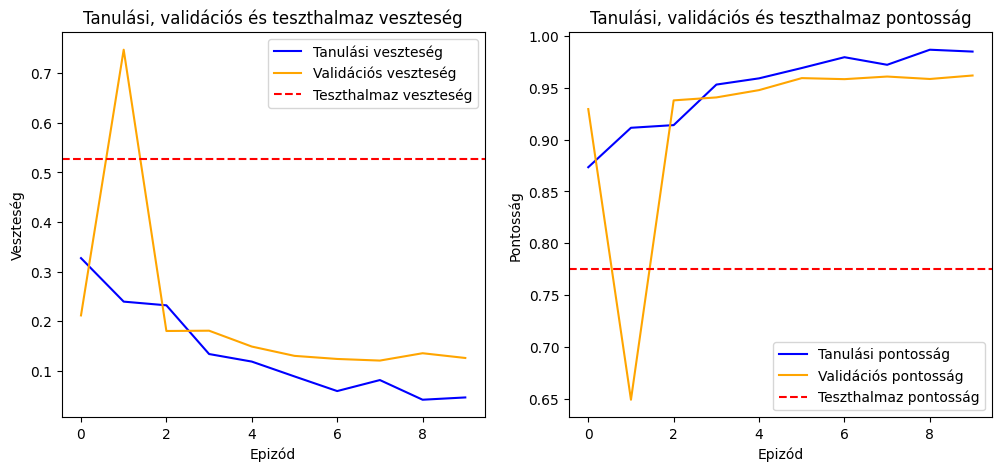

In [8]:
# Modell tesztelése a független teszthalmazon
test_loss, test_accuracy = lstm_trainable.evaluate(padded_test, y_test)

# Plot tanulási, validációs és teszt veszteség
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history_trainable.history['loss'], label='Tanulási veszteség', color='blue')
plt.plot(lstm_history_trainable.history['val_loss'], label='Validációs veszteség', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Teszthalmaz veszteség')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Plot tanulási, validációs és teszt pontosság
plt.subplot(1, 2, 2)
plt.plot(lstm_history_trainable.history['accuracy'], label='Tanulási pontosság', color='blue')
plt.plot(lstm_history_trainable.history['val_accuracy'], label='Validációs pontosság', color='orange')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Teszthalmaz pontosság')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Pontosság')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.show()


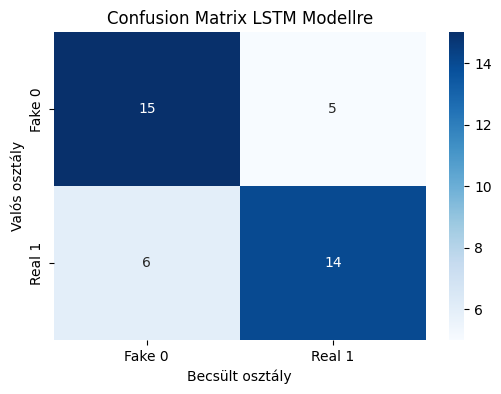

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        20
         1.0       0.74      0.70      0.72        20

    accuracy                           0.72        40
   macro avg       0.73      0.72      0.72        40
weighted avg       0.73      0.72      0.72        40



In [9]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, lstm_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake 0", "Real 1"], yticklabels=["Fake 0", "Real 1"])
plt.xlabel('Becsült osztály')
plt.ylabel('Valós osztály')
plt.title('Confusion Matrix LSTM Modellre')
plt.show()

print(classification_report(y_test, lstm_y_pred))


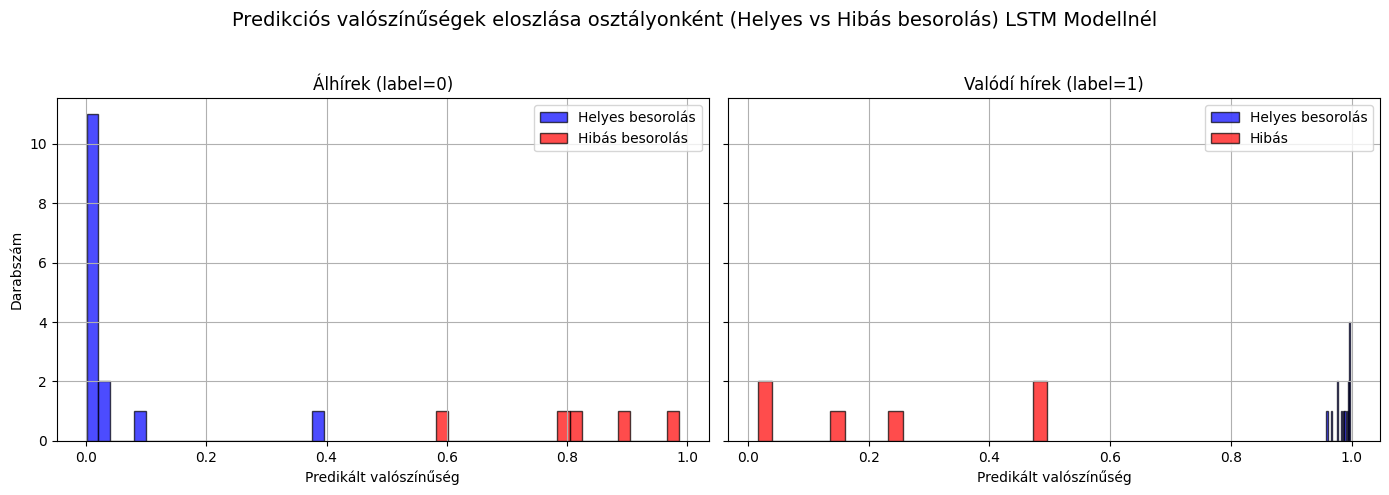

In [10]:
# Flatten
y_true = y_test.flatten()
y_pred = lstm_y_pred.flatten()
y_prob = lstm_y_prob.flatten()

# Valódi hírek (label=1)
true_real_indices = np.where(y_true == 1)[0]
correct_real = y_prob[(y_true == 0) & (y_pred == 0)]
incorrect_real = y_prob[(y_true == 0) & (y_pred != 0)]

# Álhírek (label=0)
true_fake_indices = np.where(y_true == 0)[0]
correct_fake = y_prob[(y_true == 1) & (y_pred == 1)]
incorrect_fake = y_prob[(y_true == 1) & (y_pred != 1)]

# Plot - két hisztogram egymás mellett
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Álhírek (label = 0)
axes[0].hist(correct_real, bins=20, alpha=0.7, label="Helyes besorolás", color="blue", edgecolor="black")
axes[0].hist(incorrect_real, bins=20, alpha=0.7, label="Hibás besorolás", color="red", edgecolor="black")
axes[0].set_title("Álhírek (label=0)")
axes[0].set_xlabel("Predikált valószínűség")
axes[0].set_ylabel("Darabszám")
axes[0].legend()
axes[0].grid(True)

# Valódi hírek (label = 1)
axes[1].hist(correct_fake, bins=20, alpha=0.7, label="Helyes besorolás", color="blue", edgecolor="black")
axes[1].hist(incorrect_fake, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[1].set_title("Valódí hírek (label=1)")
axes[1].set_xlabel("Predikált valószínűség")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Predikciós valószínűségek eloszlása osztályonként (Helyes vs Hibás besorolás) LSTM Modellnél", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [11]:
# DataFrame a valódi és predikált címkékkel
df_results = pd.DataFrame({
    "Valódi címke": y_test.flatten(),
    "Prediktált címke": lstm_y_pred.flatten()
})

# Félrebesorolt példák kiszűrése
df_misclassified = df_results[df_results["Valódi címke"] != df_results["Prediktált címke"]].copy()
misclassified_indices = df_misclassified.index

# Tokenizált bemenetek kiválasztása a félrebesorolt példákhoz
misclassified_sequences = padded_test[misclassified_indices]

# Tokenek visszaalakítása szöveggé
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)

# <OOV> kiszűrése a szövegekből
misclassified_texts_cleaned = []
for text in misclassified_texts:
    cleaned_text = " ".join([word for word in text.split() if word.lower().strip() not in ["<oov>", "oov", "[oov]", "(oov)"]])
    misclassified_texts_cleaned.append(cleaned_text)

# Szöveg hozzáadása a táblázathoz
df_misclassified["Szöveg"] = misclassified_texts_cleaned

# Hibatípus meghatározása (FP vagy FN)
df_misclassified.insert(0, "Hiba típusa", df_misclassified.apply(
    lambda row: "Hamis pozitív (FP)" if row["Valódi címke"] == 0 else "Hamis negatív (FN)", axis=1))

# Valószínűségek hozzáadása
misclassified_probs = lstm_y_prob[misclassified_indices].flatten()
df_misclassified["Predikció valószínűsége"] = np.round(misclassified_probs, 4)

# Fájl mentése
file_path = "/content/felrebesorolt_peldak_clean_lstm.csv"
df_misclassified.to_csv(file_path, index=False, encoding="utf-8")

# Táblázat megjelenítése
pd.set_option("display.max_colwidth", None)
display(df_misclassified.head(20))


Hiba típusa  Valódi címke  Prediktált címke  \
3   Hamis negatív (FN)           1.0                 0   
4   Hamis negatív (FN)           1.0                 0   
12  Hamis negatív (FN)           1.0                 0   
13  Hamis negatív (FN)           1.0                 0   
15  Hamis negatív (FN)           1.0                 0   
19  Hamis negatív (FN)           1.0                 0   
21  Hamis pozitív (FP)           0.0                 1   
22  Hamis pozitív (FP)           0.0                 1   
23  Hamis pozitív (FP)           0.0                 1   
24  Hamis pozitív (FP)           0.0                 1   
26  Hamis pozitív (FP)           0.0                 1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# GRU MODELL 3. ELŐFELDOLGOZÁSNÁL


### Modell lefuttatása

In [12]:
# GRU Modell

def create_gru_model(trainable_embeddings=True):
    # Szöveges input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
    text_embedding = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),  # Ensure within vocab limit
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=trainable_embeddings  # Toggle trainability
    )(text_input)

    # GRU rétegek
    gru_out = GRU(128, return_sequences=True, dropout=0.3)(text_embedding)
    gru_out = Dropout(0.3)(gru_out)  # Dropout réteg az első GRU után
    gru_out = GRU(64,return_sequences=True, dropout=0.3)(gru_out)
    gru_out = Dropout(0.3)(gru_out)
    gru_out = GRU(32, dropout=0.3)(gru_out)

    # Kimeneti réteg
    output = Dense(1, activation='sigmoid')(gru_out)  # Binary classification

    # Modell létrehozása
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modell létrehozása (Trainable)
gru_trainable = create_gru_model(trainable_embeddings=True)

gru_trainable.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 600, 300)            │       7,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 600, 128)            │         165,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 600, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 600, 64)             │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 600, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,711,809 (29.42 MB)

 Trainable params: 7,711,809 (29.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Korai leállítás beállítása
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# GRU modell tanítása a validációs adatok figyelésével
history_gru_trainable = gru_trainable.fit(
    padded_train_final, y_train_final,  # Ugyanaz a tanító adathalmaz, mint az LSTM-nél
    validation_data=(padded_val, y_val),  # Ugyanaz a validációs halmaz, mint az LSTM-nél
    epochs=10, batch_size=64, callbacks=[early_stopping]
)

# Végső tesztelés a teljesen független teszthalmazon
test_loss_gru, test_accuracy_gru = gru_trainable.evaluate(padded_test, y_test)
print(f"Teszthalmaz pontosság (GRU): {test_accuracy_gru:.4f}, Teszthalmaz veszteség (GRU): {test_loss_gru:.4f}")

Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.8082 - loss: 0.4111 - val_accuracy: 0.8999 - val_loss: 0.2706
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 84s 80ms/step - accuracy: 0.9107 - loss: 0.2344 - val_accuracy: 0.9526 - val_loss: 0.1297
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.9660 - loss: 0.0940 - val_accuracy: 0.9580 - val_loss: 0.1118
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - accuracy: 0.9791 - loss: 0.0627 - val_accuracy: 0.9724 - val_loss: 0.0860
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.9892 - loss: 0.0356 - val_accuracy: 0.9719 - val_loss: 0.0915
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.9948 - loss: 0.0173 - val_accuracy: 0.9711 - val_loss: 0.1061
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 84s 80ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9664 - val_loss: 0.1443
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8208 - loss: 0.5816 
Teszthalmaz ponto

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Valószínűség becslése
gru_y_prob = gru_trainable.predict(padded_test)

gru_y_pred = (gru_y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, gru_y_pred)
precision = precision_score(y_test, gru_y_pred)
recall = recall_score(y_test, gru_y_pred)
f1 = f1_score(y_test, gru_y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
Accuracy: 0.8000
Precision: 0.7727
Recall: 0.8500
F1-score: 0.8095


## GRU modell ábrák

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7562 - loss: 0.5410


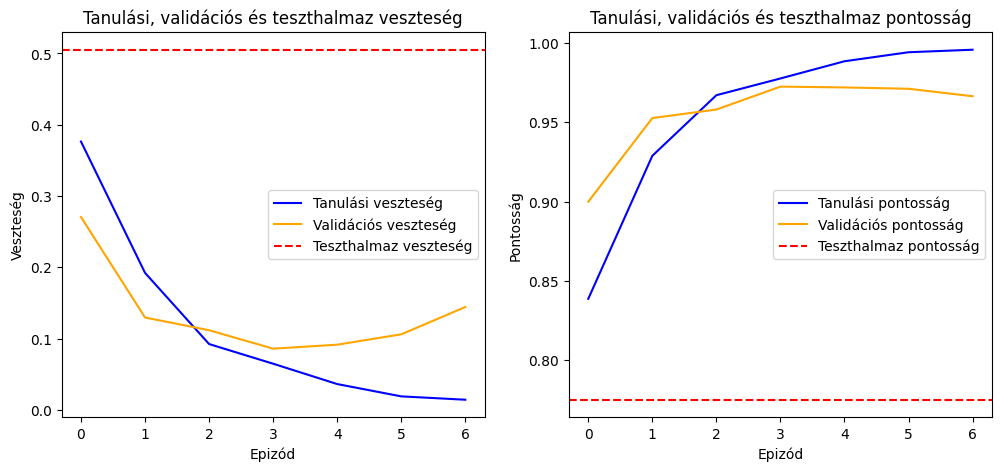

In [15]:
# Modell tesztelése a független teszthalmazon
test_loss, test_accuracy = lstm_trainable.evaluate(padded_test, y_test)

# Plot tanulási, validációs és teszt veszteség
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru_trainable.history['loss'], label='Tanulási veszteség', color='blue')
plt.plot(history_gru_trainable.history['val_loss'], label='Validációs veszteség', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Teszthalmaz veszteség')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Plot tanulási, validációs és teszt pontosság
plt.subplot(1, 2, 2)
plt.plot(history_gru_trainable.history['accuracy'], label='Tanulási pontosság', color='blue')
plt.plot(history_gru_trainable.history['val_accuracy'], label='Validációs pontosság', color='orange')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Teszthalmaz pontosság')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Pontosság')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.show()


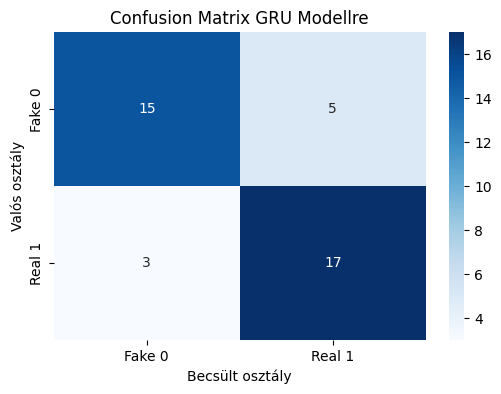

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79        20
         1.0       0.77      0.85      0.81        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



In [16]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, gru_y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake 0", "Real 1"], yticklabels=["Fake 0", "Real 1"])
plt.xlabel('Becsült osztály')
plt.ylabel('Valós osztály')
plt.title('Confusion Matrix GRU Modellre')
plt.show()

print(classification_report(y_test, gru_y_pred))

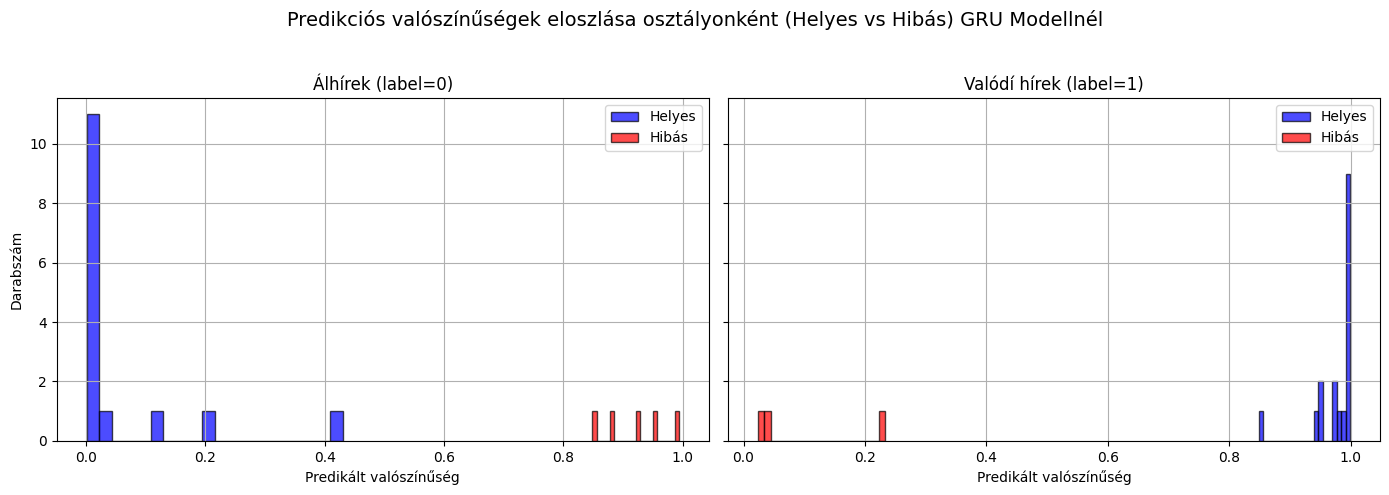

In [17]:
# Flatten
y_true = y_test.flatten()
y_pred = gru_y_pred.flatten()
y_prob = gru_y_prob.flatten()

# Valódi hírek (label=1)
true_real_indices = np.where(y_true == 1)[0]
correct_real = y_prob[(y_true == 0) & (y_pred == 0)]
incorrect_real = y_prob[(y_true == 0) & (y_pred != 0)]

# Álhírek (label=0)
true_fake_indices = np.where(y_true == 0)[0]
correct_fake = y_prob[(y_true == 1) & (y_pred == 1)]
incorrect_fake = y_prob[(y_true == 1) & (y_pred != 1)]

# Plot - két hisztogram egymás mellett
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Álhírek (label = 0)
axes[0].hist(correct_real, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[0].hist(incorrect_real, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[0].set_title("Álhírek (label=0)")
axes[0].set_xlabel("Predikált valószínűség")
axes[0].set_ylabel("Darabszám")
axes[0].legend()
axes[0].grid(True)

# Valódi hírek (label = 1)
axes[1].hist(correct_fake, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[1].hist(incorrect_fake, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[1].set_title("Valódí hírek (label=1)")
axes[1].set_xlabel("Predikált valószínűség")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Predikciós valószínűségek eloszlása osztályonként (Helyes vs Hibás) GRU Modellnél", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
# DataFrame a valódi és predikált címkékkel
df_results = pd.DataFrame({
    "Valódi címke": y_test.flatten(),
    "Prediktált címke": gru_y_pred.flatten()
})

# Félrebesorolt példák kiszűrése
df_misclassified = df_results[df_results["Valódi címke"] != df_results["Prediktált címke"]].copy()
misclassified_indices = df_misclassified.index

# Tokenizált bemenetek kiválasztása a félrebesorolt példákhoz
misclassified_sequences = padded_test[misclassified_indices]

# Tokenek visszaalakítása szöveggé
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)

# <OOV> kiszűrése a szövegekből
misclassified_texts_cleaned = []
for text in misclassified_texts:
    cleaned_text = " ".join([word for word in text.split() if word.lower().strip() not in ["<oov>", "oov", "[oov]", "(oov)"]])
    misclassified_texts_cleaned.append(cleaned_text)

# Szöveg hozzáadása a táblázathoz
df_misclassified["Szöveg"] = misclassified_texts_cleaned

# Hibatípus meghatározása (FP vagy FN)
df_misclassified.insert(0, "Hiba típusa", df_misclassified.apply(
    lambda row: "Hamis pozitív (FP)" if row["Valódi címke"] == 0 else "Hamis negatív (FN)", axis=1))

# Valószínűségek hozzáadása
misclassified_probs = gru_y_prob[misclassified_indices].flatten()
df_misclassified["Predikció valószínűsége"] = np.round(misclassified_probs, 4)

# Fájl mentése
file_path = "/content/felrebesorolt_peldak_clean_gru.csv"
df_misclassified.to_csv(file_path, index=False, encoding="utf-8")

# Táblázat megjelenítése
pd.set_option("display.max_colwidth", None)
display(df_misclassified.head(20))


Hiba típusa  Valódi címke  Prediktált címke  \
13  Hamis negatív (FN)           1.0                 0   
15  Hamis negatív (FN)           1.0                 0   
19  Hamis negatív (FN)           1.0                 0   
22  Hamis pozitív (FP)           0.0                 1   
23  Hamis pozitív (FP)           0.0                 1   
24  Hamis pozitív (FP)           0.0                 1   
27  Hamis pozitív (FP)           0.0                 1   
33  Hamis pozitív (FP)           0.0                 1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Tanulás-validáció-teszt összehasonlítása két modellnél

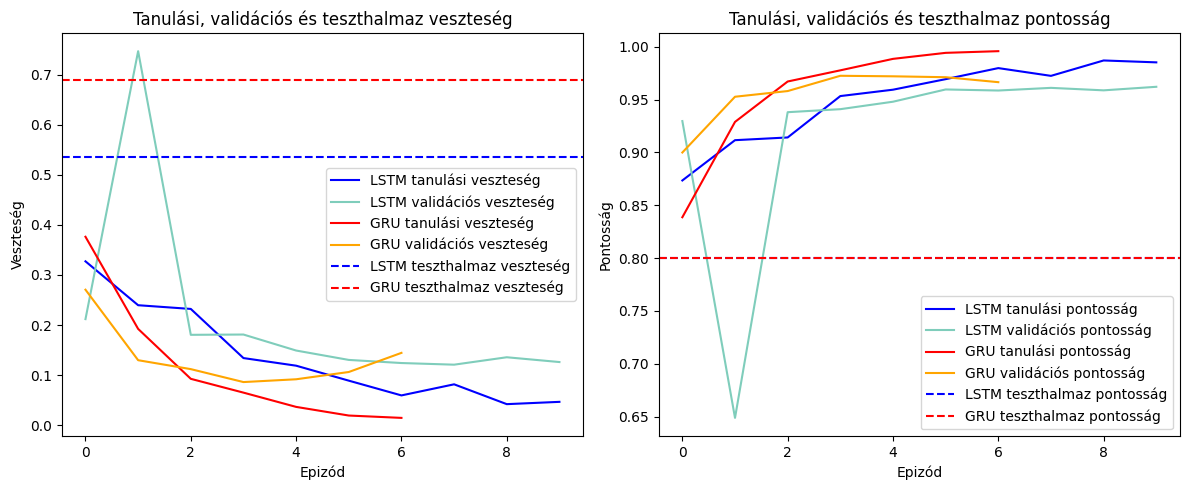

In [19]:
test_loss_lstm, test_accuracy_lstm = lstm_trainable.evaluate(padded_test, y_test, verbose=0)
test_loss_gru, test_accuracy_gru = gru_trainable.evaluate(padded_test, y_test, verbose=0)

# Ábra létrehozása két alábrával
plt.figure(figsize=(12, 5))

# Tanulási, validációs és teszthalmaz veszteség ábrázolása
plt.subplot(1, 2, 1)
plt.plot(lstm_history_trainable.history['loss'], label='LSTM tanulási veszteség', color='blue')
plt.plot(lstm_history_trainable.history['val_loss'], label='LSTM validációs veszteség', color='#7fcdbb')
plt.plot(history_gru_trainable.history['loss'], label='GRU tanulási veszteség', color='red')
plt.plot(history_gru_trainable.history['val_loss'], label='GRU validációs veszteség', color='orange')
plt.axhline(y=test_loss_lstm, color='blue', linestyle='--', label='LSTM teszthalmaz veszteség')  # LSTM teszt loss
plt.axhline(y=test_loss_gru, color='red', linestyle='--', label='GRU teszthalmaz veszteség')  # GRU teszt loss
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Ttanulási, validációs és teszthalmaz precízió ábrázolása
if 'accuracy' in lstm_history_trainable.history and 'accuracy' in history_gru_trainable.history:
    plt.subplot(1, 2, 2)
    plt.plot(lstm_history_trainable.history['accuracy'], label='LSTM tanulási pontosság', color='blue')
    plt.plot(lstm_history_trainable.history['val_accuracy'], label='LSTM validációs pontosság', color='#7fcdbb')
    plt.plot(history_gru_trainable.history['accuracy'], label='GRU tanulási pontosság', color='red')
    plt.plot(history_gru_trainable.history['val_accuracy'], label='GRU validációs pontosság', color='orange')
    plt.axhline(y=test_accuracy_lstm, color='blue', linestyle='--', label='LSTM teszthalmaz pontosság')  # LSTM teszt accuracy
    plt.axhline(y=test_accuracy_gru, color='red', linestyle='--', label='GRU teszthalmaz pontosság')  # GRU teszt accuracy
    plt.xlabel('Epizód')
    plt.ylabel('Pontosság')
    plt.legend()
    plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.tight_layout()
plt.show()
